# Intermediate Theano

In this installment of the hard-skills series, we will apply what we learned about Theano to build artificial neural networks to solve machine learning problems. First lets review some basic concepts.

### Theano Introduction Review

From the first installment, we introduced the following major concepts:
* Symbolic variables - stateless 
* Shared variables - statefull
* Gradients
    * Loss
    * Parameters
* Theano functions
    * Updates
    
Here's they are all being used in the matching example from the previous talk:

In [1]:
import theano
import numpy as np
import theano.tensor as t

In [2]:
def matching_function():
    
    # symbolic variable for target
    y = t.fmatrix()
    
    # shared variable for paramters
    x = theano.shared(np.random.rand(5, 5))
    
    # loss function to calculate cost
    loss = t.sqrt(t.sum(t.sqr(x - y)))
    
    # paramters to update
    params = [x]
    
    # gradients of parameters wrt loss
    grads = t.grad(loss, params)
    
    # updates for parameters (gradient descent)
    updates = [(p, p - 0.01 * g) for p, g in zip(params, grads)]
    
    # function that we can call that performs operations and updates parameters
    function = theano.function([y], loss, allow_input_downcast=True, updates=updates)
    
    return function, x

As before, we can generate a target and iteratively update our weights using gradient descent so that our parameters closely match our target as follows:

In [3]:
# define our target and get our model/parameters
target = np.random.rand(5, 5)
function_, x_ = matching_function()

# create numpy version of loss
def numpy_mse(x, y):
    return np.sqrt(np.sum(np.square(x - y)))

# print difference before training
print "Difference between target and parameters before training: {0}".format(
    numpy_mse(target, x_.get_value())
)

# train the model for 200 iterations
for i in xrange(400):
    function_(target)

# print the difference after training
print "Difference between target and parameters after training: {0}".format(
    numpy_mse(target, x_.get_value())
) 

Difference between target and parameters before training: 2.35094218713
Difference between target and parameters after training: 0.00905776011582


As stated in the previous talk, this is a trivial example because it is only trying to match some random parameters to some target. However, these basic elements make up the foundational components in models that can be built in Theano.

## Artificial Neural Networks in Theano

In the field of machine learning, arftificial neural networks, specificlly those under the umbrella of Deep Learning, have received special attention in the last couple of years due to their surprising effectiveness and applicability to a wide range of problems. 

![google deepnet](assets/google_deepnet.png)

Let's focus on supervised learning where we have some data with labels associated with it and our goal is develop some machine learning algorithm that takes the data as input and accurately predicts their respective labels. 

![iris dataset](assets/iris.jpg)

As our main example, we'll consider a binary classification task over some 2D data generated from a isotropic normal distribution centered at zero with unit variance. We'll assign labels to this generated data using the the "exclusive or" or "XOR" function, which assigns a 0 if the product of $x_i$ and $x_j$ is positive and a 1 otherwise (in other words - only one or the other is positive). 

In [4]:
import numpy as np

def xor_data_generator(examples=1000):

    # generate randomly distributed data around zero 
    x = np.random.randn(examples, 2)
    
    # assign labels using XOR function
    y = []
    for sample in xrange(x.shape[0]):
        if x[sample, 0] * x[sample, 1] > 0:
            y.append(0)
        else:
            y.append(1)
    y = np.asarray(y)
    
    return x, y

Now lets visualize the data. 

/Users/dan/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


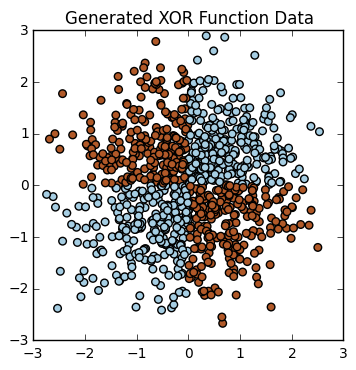

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_xor_data():

    # get xor data
    x, y = xor_data_generator()
    
    # plot the data
    plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Generated XOR Function Data')
    
plot_xor_data()

Now let's try and build a neural network that can classify these inputs to their respective labels. We can treat neural networks as a general type of function that we want to map inputs to desired outputs:

$$ y \approx h_{W,b}(x) $$

where $h$ is some function paramterized by $W$ and $b$, which represent weights and biases, respectively. So we want to find some set of paramters $[W, b]$ that do the best job of predicting what $y$ is given our function $h$. 

For this tutorial, we will strictly consider fully-connected feed-forward networks. This means that each artificial neuron is fully connected to its inputs and outputs are calculated by a single forward pass through the graph of operations that we define. For each neuron, our function $h$ is simply the weighted sum of its inputs plus the intercept (bias term):

<img src="assets/SingleNeuron.png" width="350" height="200" />

$$h_{W,b}(x) = \Big(\sum_i W_i x_i \Big) + b$$

Let's first consider a very simple neural network with one hidden layer of $N$ neurons and a single output neuron that predicts the label of the input. 

![basic network](assets/basic_network.png)

The input $x$ is first projected into the hidden layer:

$$a^{(2)} = f(xW^T + b)$$

where $f$ is some activation function, such as a sigmoid function that squeezes values into the interval $[0, 1]$. In our XOR data example, $x$ is 2-dimensional and we generate $1000$ examples for training, resulting in a $1000 \times 2$ matrix. Our hidden neurons are fully connected to the input, so each must have two weights for each neuron in our hidden layer. Our paramters for layer $L_2$ will be of size $N \times 2$ and $N \times 1$, for $W$ and $b$, respectively. The activation output $a^{(2)}$ from the matrix multiplication is then $1000 \times N$.  

Our loss can then be calculated as the difference between the predicted label and the actual label. For binary classification tasks, it is common to use "binary cross-entropy": 

$$H_{y'}(y) := - \sum_{i} ({y_i' \log(y_i) + (1-y_i') \log (1-y_i)})$$

where $y'$ and $y$ are the actual and predicted labels, respectively. 

Now lets build a function in theano that creates a model with $N$ neurons in the hidden layer. 

In [6]:
import theano
import theano.tensor as t
from theano.tensor.nnet.nnet import sigmoid, binary_crossentropy

In [7]:
def build_model(neurons=1):

    # symbolic variables for data and labels
    x = t.fmatrix('x')
    y = t.ivector('y')

    # shared variables for parameters of hidden layer and output node
    w_hidden = theano.shared(np.random.rand(neurons, 2))
    b_hidden = theano.shared(np.zeros(neurons,))
    w_out = theano.shared(np.random.rand(1, neurons)) 
    b_out = theano.shared(np.zeros(1,))
    
    # computations for hidden and output layer
    hidden = sigmoid(t.dot(x, w_hidden.T) + b_hidden.dimshuffle('x', 0))
    out = sigmoid(t.dot(hidden, w_out.T) + b_out.dimshuffle('x', 0))

    # define loss as binary cross-entropy
    loss = binary_crossentropy(out.flatten(), y).mean()

    # put our paramters in list and calculate gradients
    params = [w_hidden, b_hidden, w_out, b_out]
    grads = t.grad(loss, params)

    # define updates as gradient descent with set learning rate
    lr = 0.01
    updates = [(p, p - lr * g) for p, g in zip(params, grads)]
    
    # create training function that updates paramters based on calculated loss
    train_function = theano.function([x, y], [out, loss], allow_input_downcast=True, updates=updates)
    
    # create prediction function that does not make any updates
    out_function = theano.function([x], out, allow_input_downcast=True)
    
    return train_function, out_function

Next, lets create functions for data pre-processing and model training that we can re-use many times. 

In [8]:
def data_preprocessing(x):
    
    # normalize data to zero-mean and unit-variance
    x -= np.mean(x, axis=0)
    x /= np.std(x, axis=0)
    
    return x


def train_model(train_function, data, nb_epochs=1000):

    # separate data and get number of examples
    x, y = data
    examples = x.shape[0]

    # no preprocessing needed, but just for demonstration
    x = data_preprocessing(x)

    # perform many iterations of updates
    loss_running = []
    for epoch in xrange(nb_epochs):
        
        # shuffle the data
        rand_indices = np.random.permutation(examples)
        x = x[rand_indices]
        y = y[rand_indices]
        
        # perform mini-batches
        batch_size = 10
        n_batches = examples / batch_size
        batch_loss = 0
        for batch in xrange(n_batches):
            start = batch * batch_size
            end = start + batch_size
            out_, loss_iteration = train_function(x[start:end], y[start:end])
            batch_loss += loss_iteration
            
        # append average mini-batch loss for epoch to running loss
        avg_batch_loss = batch_loss / n_batches
        loss_running.append(avg_batch_loss)
        
        # break out if under certain loss
        if avg_batch_loss < 0.1:
            break

    plt.plot(loss_running)
    plt.title('Training Loss Across Iterations')

Now lets use the above modules to build a model with only a single neuron in the hidden layer and see what it can do. 

In [9]:
xor_train_data = xor_data_generator()  # get 1000 examples of XOR training data

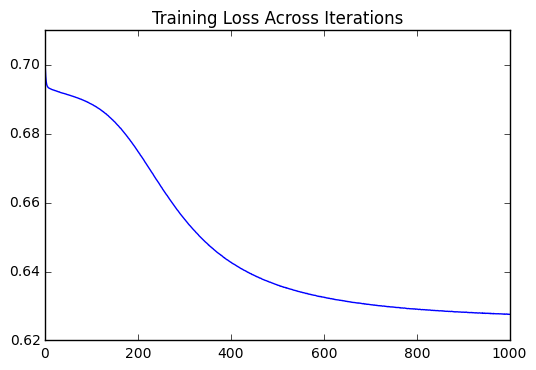

In [72]:
train_fun, out_fun = build_model(neurons=1) # get training and prediction functions for model with 1 neuron
train_model(train_fun, data=xor_train_data)  # train the model on the XOR data

We can see that the loss function is going down, which is a good sign!

Let's generate some test data as well and compare the accuracy on this relative to the training data. 

In [73]:
xor_test_data = xor_data_generator()  # get 1000 examples of testing data

In [74]:
def accuracy_calc(data, prob_pred):
    
    # get labels from data 
    _, true = data
    
    # round the predicted probabilites to get predicted class
    predicted = np.around(prob_pred).squeeze()
    
    # calculate accuracy
    accuracy = 1 - np.mean(np.abs(true - predicted))
    return accuracy


def get_predicted_probabilities(data, out_function):
    
    # get data and return predicted probabilities
    x, _ = data
    return out_function(x)


def compare_accuracies(data, out_function):
    
    # separate training and test data
    train_data, test_data = data
    
    # get predictions and calculate accurcies for both datas sets
    train_prob = get_predicted_probabilities(train_data, out_function)
    test_prob = get_predicted_probabilities(test_data, out_function)
    train_acc = accuracy_calc(train_data, train_prob)
    test_acc = accuracy_calc(test_data, test_prob)
    print "Training data accuracy: {0}".format(train_acc)
    print "Testing data accuracy: {0}".format(test_acc)

In [75]:
compare_accuracies((xor_train_data, xor_test_data), out_fun)

Training data accuracy: 0.64
Testing data accuracy: 0.608


To get an idea of what it is doing, let's visualize it's decision surface by getting the prediction of the network at all points in a grid and then underlaying that behind the training data. 

In [48]:
def get_mesh():
    
    return np.meshgrid(
        np.linspace(-3, 3, 50),
        np.linspace(-3, 3, 50)
    )


def get_decision_boundary(out_function, data):
    
    xx, yy = get_mesh()
    x, y = data
    
    # get the predictions of network for all points in the grid
    decision_boundary = out_function(np.vstack((xx.ravel(), yy.ravel())).T).reshape(xx.shape)
    
    return decision_boundary

def visualize_decision_boundary(decision_boundary, data, subset=None):

    """
    Plot the decision surface behind the data. 
    """
    
    xx, yy = get_mesh()
    x, y = data
    x = x[:subset]
    y = y[:subset]
    
    image = plt.imshow(np.abs(decision_boundary - 1), interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.RdBu)
    contours = plt.contour(xx, yy, decision_boundary, levels=[0], linewidths=2,
                           linetypes='--')
    plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xticks(())
    plt.yticks(())
    plt.axis([-3, 3, -3, 3])
    plt.gca().set_aspect('equal', adjustable='box')
    plt.colorbar(image)
    plt.title('Decision Boundary')

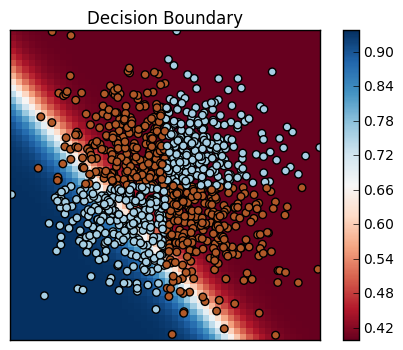

In [49]:
decision_boundary_ = get_decision_boundary(out_fun, data=xor_train_data)
visualize_decision_boundary(decision_boundary_, data=xor_train_data)

We can see that the model can basically only learn to linearly separate the data, which is clearly not a sufficient solution for this data set. 

Let's add some more neurons to the hidden layer and see what effect that has. 

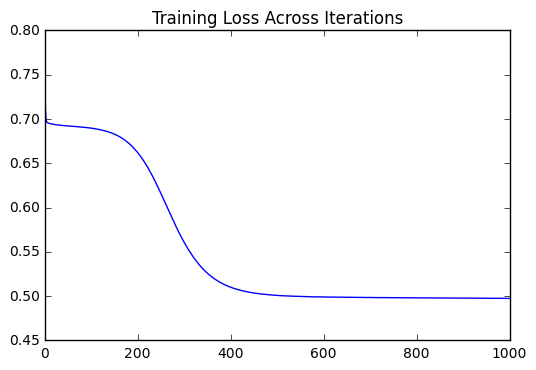

In [50]:
train_fun, out_fun = build_model(neurons=4)  # new model with four neurons
train_model(train_fun, data=xor_train_data)

First, we should note that the loss at the end of training is lower. Next, let's look at the accuracy and visualize the decision boundary. 

In [51]:
compare_accuracies((xor_train_data, xor_test_data), out_fun)

Training data accuracy: 0.766
Testing data accuracy: 0.751


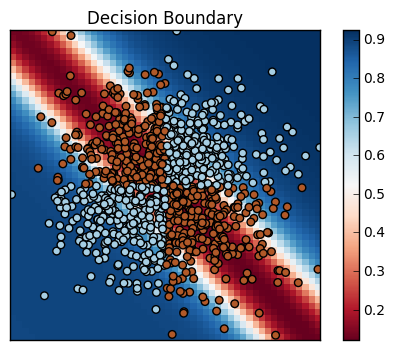

In [52]:
decision_boundary_ = get_decision_boundary(out_fun, data=xor_train_data)
visualize_decision_boundary(decision_boundary_, data=xor_train_data, subset=None)

We can see that adding more neurons to the hidden layer allows the model to learn a more interesting decision surface that is able to more accurately predict labels from the data points. However, with only one layer, the model is still limited in how well it can classify the data. 

So what about deep learning? Deep Learning is just an extension of single hidden-layer networks such that there are multiple hidden layers - hence deep learning. The multiple layers allow for these types of models to learn hierarchical and abstract features based on combining basic features in a highly non-linear way. 

Let's build a simple deep neural network to see if we can improve upon our classification performance from the previous single-layer models. To do this, we introduce two new concepts: 
* initializations - how we initialize our weights
* recitified linear units - better activation function for hidden layers

In [53]:
from theano.tensor.nnet.nnet import relu


def glorot_uniform(shape):

    # glorot uniform initialization 
    s = np.sqrt(6. / (shape[0] + shape[1])) * .3
    return theano.shared(np.random.uniform(-s, s, shape))


def deep_model(neurons=(6, 8, 6)):
    
    """
    Deep neural network with three hidden layers. 
    """

    x = t.fmatrix('x')
    y = t.ivector('y')

    w_1 = glorot_uniform(shape=(neurons[0], 2))
    b_1 = theano.shared(np.zeros(neurons[0],))
    
    w_2 = glorot_uniform(shape=(neurons[1], neurons[0]))
    b_2 = theano.shared(np.zeros(neurons[1],))
    
    w_3 = glorot_uniform(shape=(neurons[2], neurons[1]))
    b_3 = theano.shared(np.zeros(neurons[2],))
    
    w_out = glorot_uniform(shape=(1, neurons[2]))
    b_out = theano.shared(np.zeros(1,))
    
    a_1 = relu(t.dot(x, w_1.T) + b_1.dimshuffle('x', 0))
    a_2 = relu(t.dot(a_1, w_2.T) + b_2.dimshuffle('x', 0))
    a_3 = relu(t.dot(a_2, w_3.T) + b_3.dimshuffle('x', 0))
    
    out = sigmoid(t.dot(a_3, w_out.T) + b_out.dimshuffle('x', 0))

    loss = binary_crossentropy(out.flatten(), y).mean()

    params = [w_1, b_1, w_2, b_2, w_3, b_3, w_out, b_out]
    grads = t.grad(loss, params)

    lr = 0.001
    updates = [(p, p - lr * g) for p, g in zip(params, grads)]
    train_function = theano.function([x, y], [out, loss], allow_input_downcast=True, updates=updates)
    out_function = theano.function([x], out, allow_input_downcast=True,)
    
    return train_function, out_function

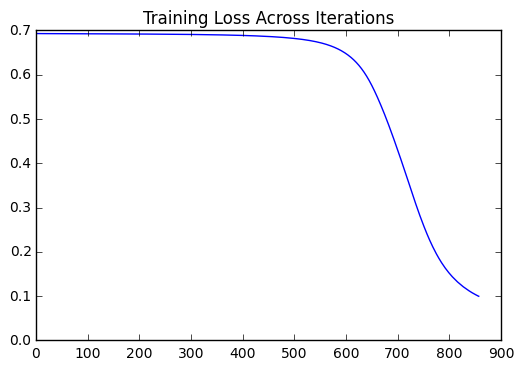

In [62]:
train_fun, out_fun = deep_model(neurons=(6, 8, 6))
train_model(train_fun, data=xor_train_data, nb_epochs=1200)

Training data accuracy: 0.992
Testing data accuracy: 0.975


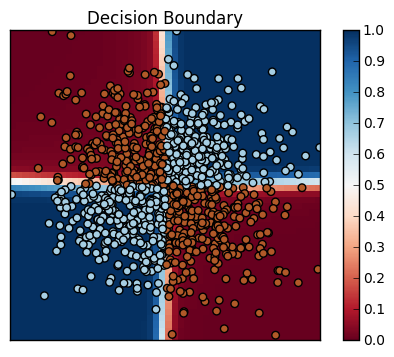

In [63]:
compare_accuracies((xor_train_data, xor_test_data), out_fun)
decision_boundary_ = get_decision_boundary(out_fun, data=xor_train_data)
visualize_decision_boundary(decision_boundary_, data=xor_train_data)

This is the solution we want. The neural network's decision surface has clearly learned the XOR function. Now we can see the power of deep learning, even in this simple example. 

Finally, let's load another dataset for comparison!

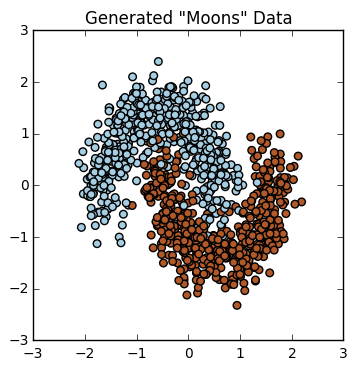

In [64]:
from sklearn.preprocessing import scale
from sklearn.datasets import make_moons


def moons_data_generator():
    
    x, y = make_moons(noise=0.2, random_state=0, n_samples=1000)
    x = scale(x)
    
    return x, y


def plot_moons_data():

    x, y = moons_data_generator()
    plt.scatter(x[:, 0], x[:, 1], s=30, c=y, cmap=plt.cm.Paired)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.title('Generated "Moons" Data')
    
    
plot_moons_data()

In [66]:
moons_train_data = moons_data_generator()
moons_test_data = moons_data_generator()

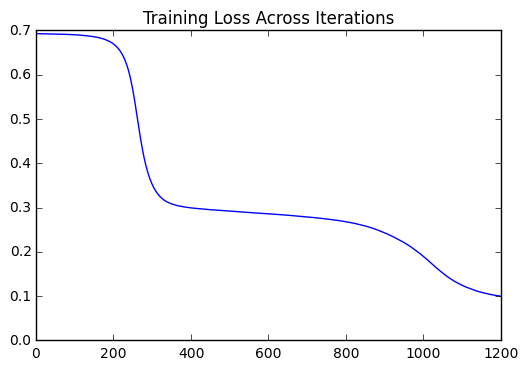

In [67]:
train_fun, out_fun = deep_model(neurons=(6, 8, 12))
train_model(train_fun, data=moons_train_data, nb_epochs=2000)

Ok loss looks good...

Training data accuracy: 0.967
Testing data accuracy: 0.967


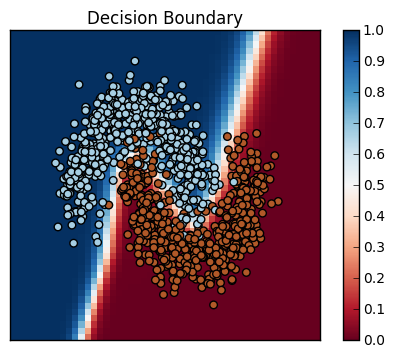

In [68]:
compare_accuracies((moons_train_data, moons_test_data), out_fun)
decision_boundary_ = get_decision_boundary(out_fun, data=moons_train_data)
visualize_decision_boundary(decision_boundary_, data=moons_train_data)

Great! We see that a deep neural network can learn a decision surface that can separate the two classes quite well. 